## Import libraries

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import SARIMAX
from statsmodels.tools.eval_measures import aic
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

pd.set_option("display.precision", 2)
plt.style.use('mystyle.mplstyle')

In [3]:
def make_a_line():
    ax.plot([0.12, .9],                  # Set width of line
        [1.05, 1.05],                  # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
        
def make_a_rec():
    ax.add_patch(plt.Rectangle((0.12,1.05),                 # Set location of rectangle by lower left corder
                           0.04,                       # Width of rectangle
                           -0.02,                      # Height of rectangle. Negative so it goes down.
                           facecolor='#E3120B', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))
    
def make_title(text):
    ax.text(x=0.12, y=0.98, s=text, 
            transform=fig.transFigure, ha='left', 
            fontsize=13, weight='bold', alpha=.8)
    
def make_description(text):
    ax.text(x=0.12, y=0.93, s=text, 
            transform=fig.transFigure, ha='left', 
            fontsize=11, alpha=.8)
    
def plot(title, text):
    make_a_line()
    make_a_rec()
    make_title(title)
    make_description(text)

## Import the file, create data frames, and create the necessary variables

In [4]:
xls = pd.ExcelFile('Data.xlsx')
df = xls.parse(0)
factors_df = xls.parse(1)

In [5]:
df['Time'] = pd.to_datetime(df['Time'])
factors_df['Time'] = pd.to_datetime(factors_df['Time'])

Limit the observations until 2018:Q3

In [6]:
df = df.iloc[0:234]
df.head()

,Time,GDPC1,PCECTPI,TB3MS,GS10
0,1960-06-30,3430.06,15.33,3.54,4.50
1,1960-09-30,3439.83,15.41,4.23,4.58
2,1960-12-30,3517.18,15.44,3.87,4.49
3,1961-03-30,3498.25,15.52,2.99,4.26
4,1961-06-30,3515.39,15.57,2.36,3.83


Create $\log(GDPC1)$ and $\Delta \log(GDPC1)$

In [7]:
df['log_GDP'] = np.log(df['GDPC1'])

df['delta_log_GDP'] = (df['log_GDP'] - df['log_GDP'].shift(1))
df['delta_log_GDP'].fillna(0, inplace=True)

Create $\pi$ and $\log(PCECTPI)$

In [8]:
df['infl'] = (np.log(df['PCECTPI']) - (np.log(df['PCECTPI'])).shift(1))
df['infl'].fillna(0, inplace=True)

df['log_PCECTPI'] = np.log(df['PCECTPI'])

Create $TSpread$

In [9]:
df['tspread'] = df['GS10'] - df['TB3MS']

In [10]:
df.head()

,Time,GDPC1,PCECTPI,TB3MS,GS10,log_GDP,delta_log_GDP,infl,log_PCECTPI,tspread
0,1960-06-30,3430.06,15.33,3.54,4.50,8.14,0.00e+00,0.00e+00,2.73,0.96
1,1960-09-30,3439.83,15.41,4.23,4.58,8.14,2.85e-03,5.46e-03,2.74,0.35
2,1960-12-30,3517.18,15.44,3.87,4.49,8.17,2.22e-02,1.30e-03,2.74,0.61
3,1961-03-30,3498.25,15.52,2.99,4.26,8.16,-5.40e-03,5.17e-03,2.74,1.27
4,1961-06-30,3515.39,15.57,2.36,3.83,8.16,4.89e-03,3.80e-03,2.75,1.47


## **Model 1: Random Walk**

Since the prediction for the next period is the last observed value, all we have to do is to shift(1) the series, and then consider only the prediction starting from 1985:Q2.

In [11]:
rw_predictions = df['log_GDP'].shift(1)

# bring it into real terms
exp_rw_predictions = np.exp(rw_predictions)

# consider only from 1985:Q3
exp_rw_predictions = exp_rw_predictions[100:]

## **Model 2: AR(4)**

In [12]:
ar_4_forecasts = []

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df.iloc[t:t+window_size]

    # create the model and fit it
    ar_4_model = ARIMA(current_window['delta_log_GDP'], order=(4,0,0)) 
    ar_4_results = ar_4_model.fit()

    # forecast the next observation
    ar_4_forecast = ar_4_results.forecast(steps=1)

    # append the forecasted value to the list
    ar_4_forecasts.append(ar_4_forecast.iloc[0])

    # roll the window
    t += 1

Now that we modelled $\Delta \hat{y_{t}}$ with an `AR(4)` model, we have to obtain the values for $\hat{y_{t}}$ coming from the `AR(4)` model.
For this reason, we need to exploit:

$\Delta \hat{y_{h}} = \hat{y}_{t+h} - \hat{y}_{t+h-1}$

$\hat{y}_{t+h} = \Delta \hat{y}_{h} + \hat{y}_{t+h-1}$

Where $\Delta \hat{y}_{h}$ is estimated thanks to the model, and the same for $\hat{y}_{t+h-1}$ which is the previous period, both included into `ar_4_forecasts`.

For loop to derive estimate of GDP from delta GDP: 

In [13]:
ar_4_GDP_estimates = np.zeros(134)
window_size = 100

for i in range(0,len(ar_4_GDP_estimates)):
    ar_4_GDP_estimates[i] = ar_4_forecasts[i] + df['log_GDP'].iloc[i+window_size-1]

ar_4_GDP_estimates = np.exp(ar_4_GDP_estimates)

## **Model: VAR(4)**
For the model VAR(4) we have to forecast $\Delta y_t$, $\pi_t$ and $Tspread_t$. In order to do I will create a new df containing only these 3 series, making it easier to pass them as an argument to the function. 

In [14]:
df_var = df[['Time', 'delta_log_GDP', 'infl', 'tspread']]
df_var = df_var.set_index('Time')
df_var.index = pd.DatetimeIndex(df_var.index).to_period('Q')

In [15]:
var_4_forecasts = pd.DataFrame(columns=['delta_log_GDP', 'infl', 'tspread'])

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df_var.iloc[t:t+window_size]

    # create the model and fit it
    var_4_model = VAR(current_window) 
    var_4_results = var_4_model.fit(4)

    # forecast the next observation
    var_4_forecast = var_4_results.forecast(y = current_window.values[-4:], steps = 1)[0]
    temp_df = pd.DataFrame({'delta_log_GDP' : [var_4_forecast[0]], 
                            'infl': [var_4_forecast[1]], 
                            'tspread': [var_4_forecast[2]]})

    # append the forecasted value to the list
    var_4_forecasts = pd.concat([var_4_forecasts, temp_df])

    # roll the window
    t += 1

In [16]:
var_4_GDP_estimates = np.zeros(134)

for i in range(0,len(var_4_GDP_estimates)):
    var_4_GDP_estimates[i] = var_4_forecasts['delta_log_GDP'].iloc[i] + df['log_GDP'].iloc[i+window_size-1]

var_4_GDP_estimates = np.exp(var_4_GDP_estimates)

## **Model: VAR(p)**

In [66]:
results = np.zeros(134)

window_size = 100

t = 0

for n in range(1, 135):
    aics = np.zeros(6)
    # determine the training data at each step
    current_window = df_var.iloc[t:t+window_size]
    var_p_model = VAR(current_window) 

    for i in [1,2,3,4,5,6]:
        result = var_p_model.fit(i)
        aics[i-1] = result.aic
        
    results[n-1] = aics.argmin()

    t += 1


In [68]:
np.mean(results)

2.462686567164179

In [17]:
var_p_forecasts = pd.DataFrame(columns=['delta_log_GDP', 'infl', 'tspread'])

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df_var.iloc[t:t+window_size]

    # create the model and fit it
    var_p_model = VAR(current_window) 
    x = var_p_model.select_order(maxlags=8)
    p = x.selected_orders['aic']
    var_p_results = var_p_model.fit(p)

    # forecast the next observation
    var_p_forecast = var_p_results.forecast(y = current_window.values[-p:], steps = 1)[0]
    temp_df = pd.DataFrame({'delta_log_GDP' : [var_p_forecast[0]], 
                            'infl': [var_p_forecast[1]], 
                            'tspread': [var_p_forecast[2]]})

    # append the forecasted value to the list
    var_p_forecasts = pd.concat([var_p_forecasts, temp_df])

    # roll the window
    t += 1


In [18]:
var_p_GDP_estimates = np.zeros(134)

for i in range(0,len(var_p_GDP_estimates)):
    var_p_GDP_estimates[i] = var_p_forecasts['delta_log_GDP'].iloc[i] + df['log_GDP'].iloc[i+window_size-1]

var_p_GDP_estimates = np.exp(var_p_GDP_estimates)

## **Model: AR(4)-X**

### Calculate Principal Component

Create `stand_factors` as a data frame containing 245 columns, namely all the columns of factors_df except the _Time_, but standardized ($\mu =0$, $\sigma=1$).

`factors_df` doesn't change.

In [19]:
stand_factors = factors_df.iloc[:, 1:].apply(stats.zscore, axis=0)

### Create the model using PC

In [74]:
ar_x_forecasts = []
pca = PCA(n_components=1)

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df.iloc[t:t+window_size]

    # create the model and fit it
    curr_stand_factors = stand_factors[t:t+window_size]

    Pcs = pca.fit_transform(curr_stand_factors)
    Pcs = np.roll(Pcs, 1)
    Pcs[0] = 0
    first_PC = Pcs[-1]

    ar_x_model = ARIMA(current_window['delta_log_GDP'], exog = Pcs,  order = (4,0,0)) 
        
    ar_x_results = ar_x_model.fit()

    # forecast the next observation
    ar_x_forecast = ar_x_results.forecast(steps=1, exog = first_PC)

    # append the forecasted value to the list
    ar_x_forecasts.append(ar_x_forecast.iloc[0])

    # roll the window
    t += 1


In [75]:
ar_x_GDP_estimates = np.zeros(134)

for i in range(0,len(ar_x_GDP_estimates)):
    ar_x_GDP_estimates[i] = ar_x_forecasts[i] + df['log_GDP'].iloc[i+window_size-1]

ar_x_GDP_estimates = np.exp(ar_x_GDP_estimates)

## **Section 1**

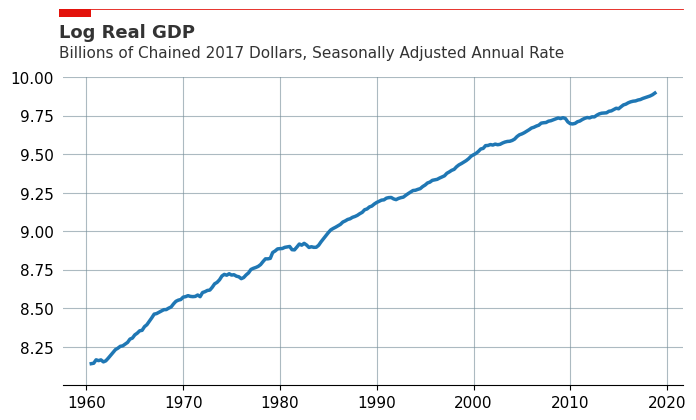

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Time'], df['log_GDP'], zorder = 2, linewidth = 2.5)
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(bottom=8, top=10)
plt.yticks([8.25, 8.50, 8.75, 9, 9.25, 9.50, 9.75,10])
plt.grid(x)
plot('Log Real GDP', 'Billions of Chained 2017 Dollars, Seasonally Adjusted Annual Rate')

plt.savefig('image\log_real_gdp.png', bbox_inches = 'tight')




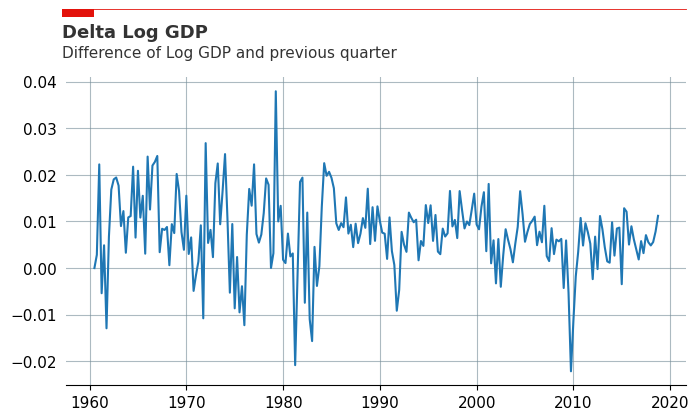

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Time'], df['delta_log_GDP'], zorder = 2, linewidth = 1.5)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(x)
plot('Delta Log GDP', 'Difference of Log GDP and previous quarter')

plt.savefig('image\delta_log_real_gdp.png', bbox_inches = 'tight')


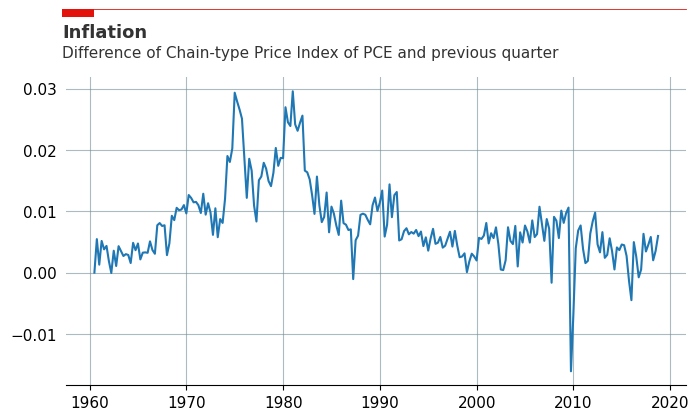

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Time'], df['infl'], zorder = 2, linewidth = 1.5)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(x)
plot('Inflation', 'Difference of Chain-type Price Index of PCE and previous quarter')

plt.savefig('image\infl.png', bbox_inches = 'tight')

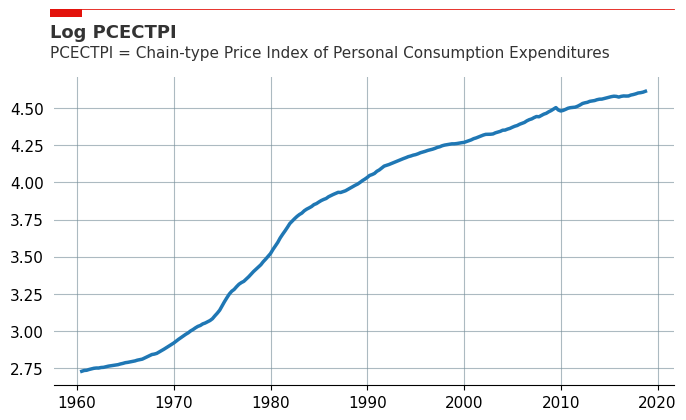

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Time'], df['log_PCECTPI'], zorder = 2, linewidth = 2.5)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(x)
plot('Log PCECTPI', 'PCECTPI = Chain-type Price Index of Personal Consumption Expenditures')
plt.savefig('image\log_PCE.png', bbox_inches = 'tight')

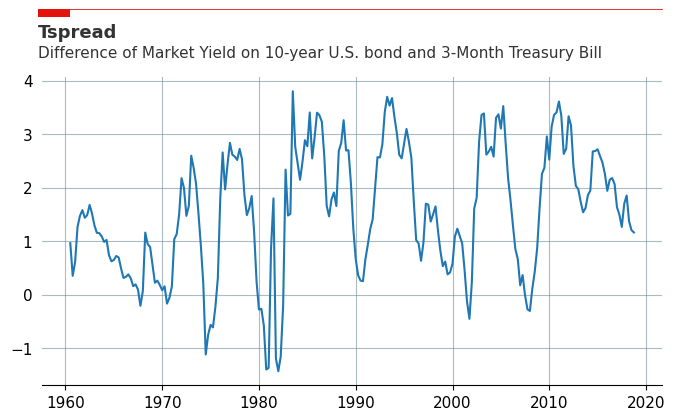

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Time'], df['tspread'], zorder = 2, linewidth = 1.5)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(x)
plot('Tspread', 'Difference of Market Yield on 10-year U.S. bond and 3-Month Treasury Bill')

plt.savefig('image\spread.png', bbox_inches = 'tight')

## **Section 2**

Compute ACF for the three series.

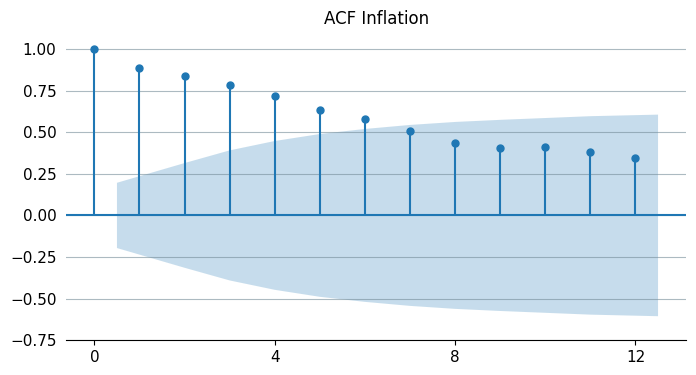

In [ ]:
plot_acf(df_var['infl'].iloc[:100], 
         lags=12, 
         title="ACF Inflation");
plt.ylim(bottom = -0.75, top= 1.1)
plt.xticks([0,4,8,12])

plt.savefig('image\ACF_inflatin.png', bbox_inches = 'tight')

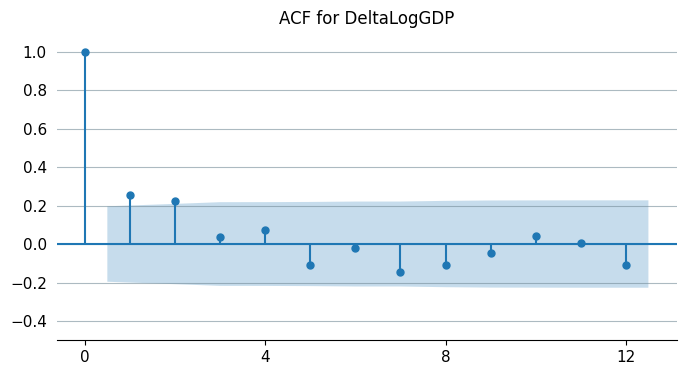

In [ ]:
plot_acf(df_var['delta_log_GDP'].iloc[:100], 
         lags=12, 
         title="ACF for DeltaLogGDP");
plt.ylim(bottom = -0.5, top = 1.1)
plt.xticks([0,4,8,12])
plt.savefig('image\ACF_deltalogGdp.png', bbox_inches = 'tight')

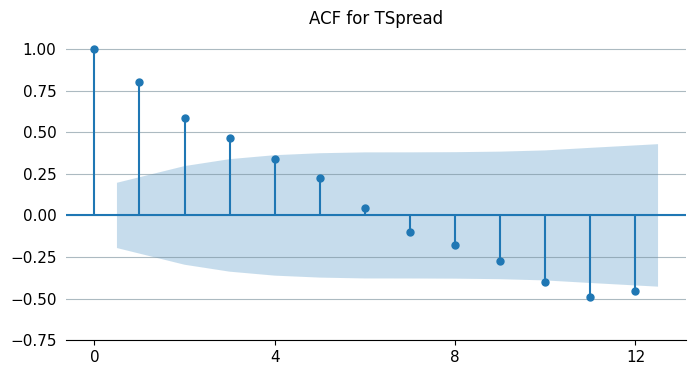

In [ ]:
plot_acf(df_var['tspread'].iloc[:100], 
         lags=12, 
         title="ACF for TSpread");
plt.ylim(bottom = -0.75, top = 1.1)
plt.xticks([0,4,8,12])

plt.savefig('image\ACF_tspread.png', bbox_inches = 'tight')

Use AIC to select the lag order.

In [ ]:
sec2_model = VAR(df_var.iloc[:100])
x = sec2_model.select_order()
p = x.selected_orders['aic']

x.summary()

,AIC,BIC,FPE,HQIC
0,-18.75,-18.67,7.165e-09,-18.72
1,-21.42,-21.08*,4.999e-10,-21.28*
2,-21.42,-20.83,4.995e-10,-21.18
3,-21.43,-20.58,4.952e-10,-21.09
4,-21.70,-20.60,3.787e-10,-21.26
5,-21.70,-20.35,3.817e-10,-21.15
6,-21.63,-20.03,4.116e-10,-20.99
7,-21.76,-19.91,3.652e-10,-21.01
8,-21.86,-19.75,3.372e-10,-21.01
9,-21.80,-19.44,3.648e-10,-20.85


Estimate the model.

In [ ]:
sec2_results = sec2_model.fit(p)
sec2_results.resid

,delta_log_GDP,infl,tspread
Time,,,
1963Q2,-2.44e-03,6.82e-04,0.08
1963Q3,-1.35e-03,-4.51e-04,-0.03
1963Q4,2.53e-04,-2.78e-03,0.08
1964Q1,-1.88e-04,-1.10e-03,-0.48
1964Q2,3.43e-03,4.47e-04,-0.10
...,...,...,...
1984Q1,9.67e-04,-3.99e-04,-0.29
1984Q2,-1.26e-03,-9.95e-04,0.17
1984Q3,6.43e-04,-2.12e-04,-0.83


Plot the residuals of the three series.

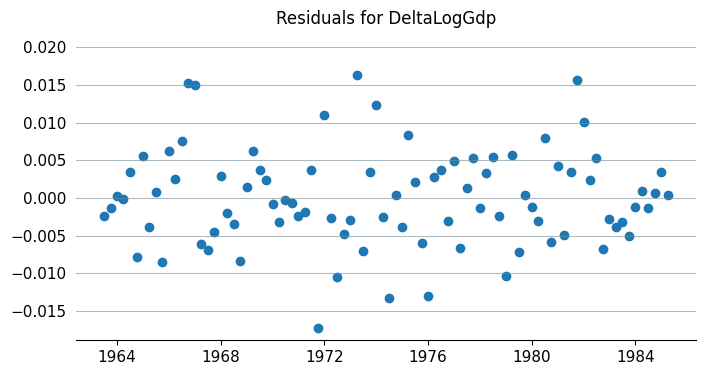

In [ ]:
plt.scatter(df['Time'].iloc[12:100], sec2_results.resid['delta_log_GDP'])
plt.title('Residuals for DeltaLogGdp')
plt.ylim(top = 0.022)

plt.savefig('image\Res_deltaloggdp.png', bbox_inches = 'tight')

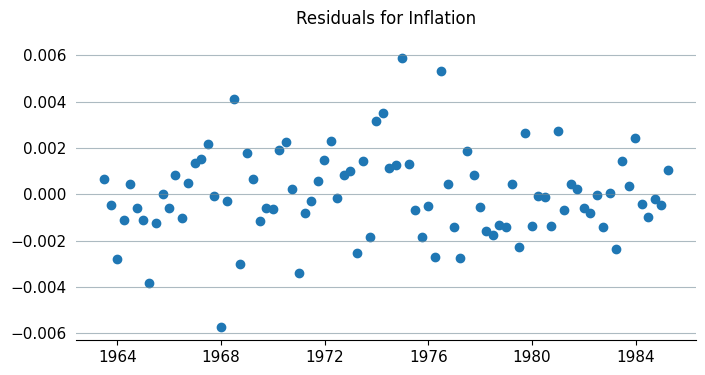

In [ ]:
plt.scatter(df['Time'].iloc[12:100], sec2_results.resid['infl'])
plt.title('Residuals for Inflation')
plt.ylim(top = 0.007)

plt.savefig('image\Res_infl.png', bbox_inches = 'tight')

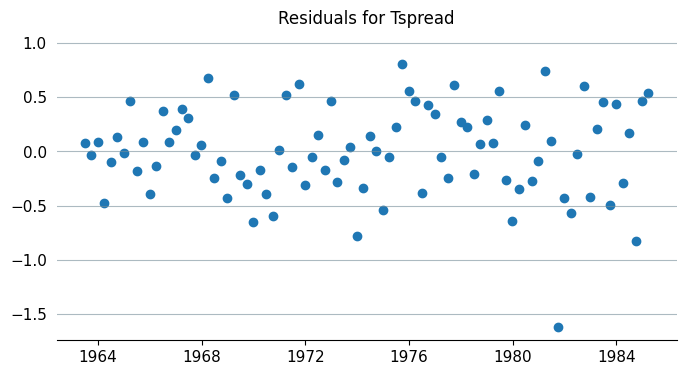

In [ ]:
plt.scatter(df['Time'].iloc[12:100], sec2_results.resid['tspread'])
plt.title('Residuals for Tspread')
plt.ylim(top = 1.1)

plt.savefig('image\Res_tspread.png', bbox_inches = 'tight')

Plot ACF of the residuals.

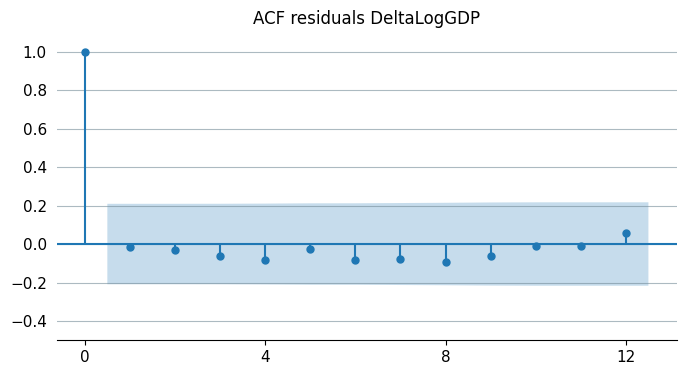

In [ ]:
plot_acf(sec2_results.resid['delta_log_GDP'].iloc[:100], 
         lags=12, 
         title="ACF residuals DeltaLogGDP");
plt.ylim(bottom =-0.5, top = 1.1)
plt.xticks([0,4,8,12])

plt.savefig('image\Acf_Res_deltalogGDP.png', bbox_inches = 'tight')

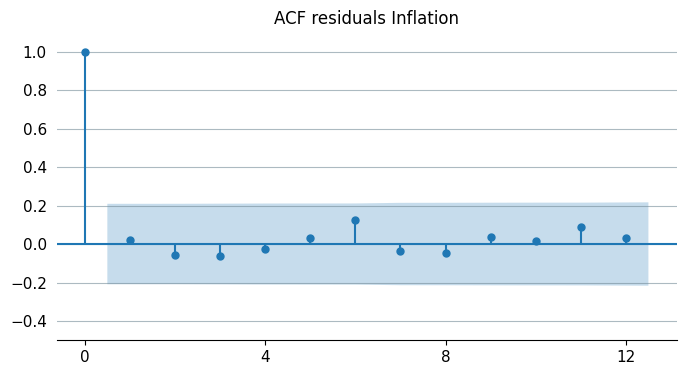

In [ ]:
plot_acf(sec2_results.resid['infl'].iloc[:100], 
         lags=12, 
         title="ACF residuals Inflation");
plt.ylim(bottom = -0.5, top = 1.1)
plt.xticks([0,4,8,12])

plt.savefig('image\Acf_Res_infl.png', bbox_inches = 'tight')

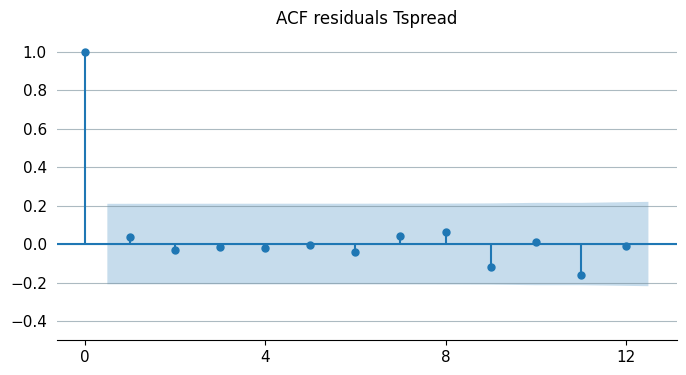

In [ ]:
plot_acf(sec2_results.resid['tspread'].iloc[:100], 
         lags=12, 
         title="ACF residuals Tspread");
plt.ylim(bottom = -0.5, top = 1.1)
plt.xticks([0,4,8,12])

plt.savefig('image\Acf_Res_tspread.png', bbox_inches = 'tight')

Plot PACFs for the residuals.

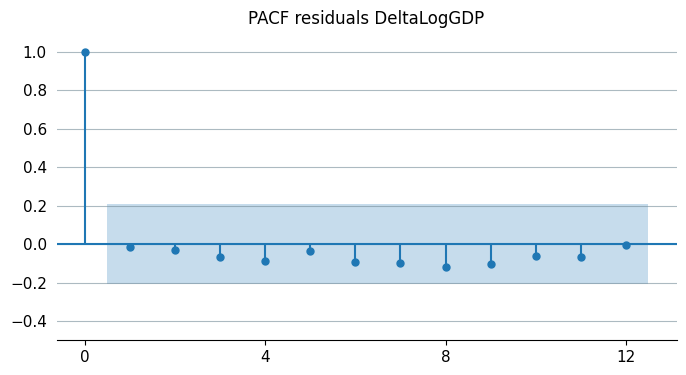

In [ ]:
plot_pacf(sec2_results.resid['delta_log_GDP'].iloc[:100], 
         lags=12, 
         title="PACF residuals DeltaLogGDP");
plt.ylim(bottom = -0.5, top = 1.1)
plt.xticks([0,4,8,12])
plt.savefig('image\PAcf_Res_DeltaLogGDP.png', bbox_inches = 'tight')

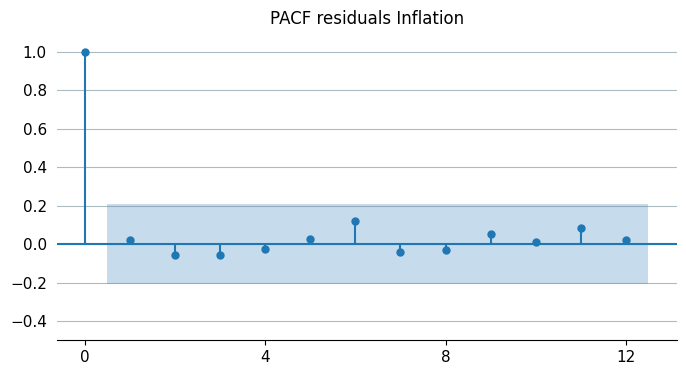

In [ ]:
plot_pacf(sec2_results.resid['infl'].iloc[:100], 
         lags=12, 
         title="PACF residuals Inflation");
plt.ylim(bottom = -0.5, top = 1.1)
plt.xticks([0,4,8,12])
plt.savefig('image\PAcf_Res_infl.png', bbox_inches = 'tight')

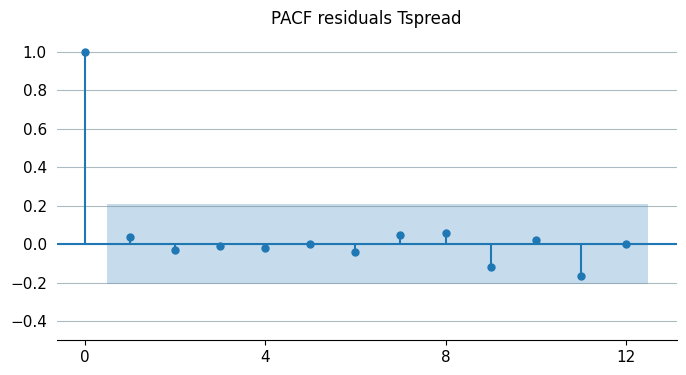

In [ ]:
plot_pacf(sec2_results.resid['tspread'].iloc[:100], 
         lags=12, 
         title="PACF residuals Tspread");
plt.ylim(bottom = -0.5, top = 1.1)
plt.xticks([0,4,8,12])

plt.savefig('image\PAcf_Res_tspread.png', bbox_inches = 'tight')

## **Section 3**

In [ ]:
sec3_pc = pca.fit_transform(stand_factors[:100])


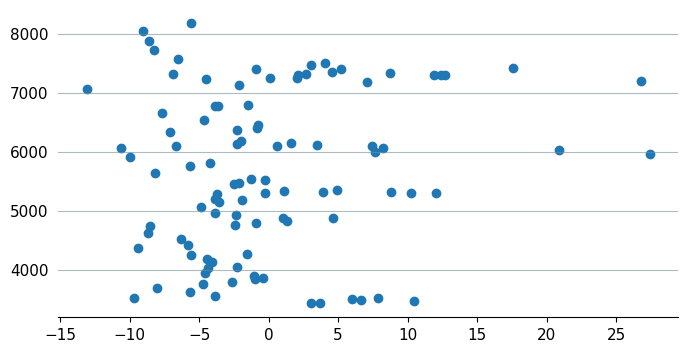

In [ ]:
plt.scatter(sec3_pc, df['GDPC1'].iloc[:100])


In [ ]:
from fredapi import Fred
fred = Fred(api_key = '3c333fd92c7d3df79f55af2ee72f13bf')
rec = fred.get_series('USRECQ', '1960-04-01', '1985-01-01')
new_df = df.iloc[:100]
new_df['rec'] = rec.values

C:\Users\tifos\AppData\Local\Temp\ipykernel_37768\3756596999.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['rec'] = rec.values


In [ ]:
from dateutil.relativedelta import relativedelta


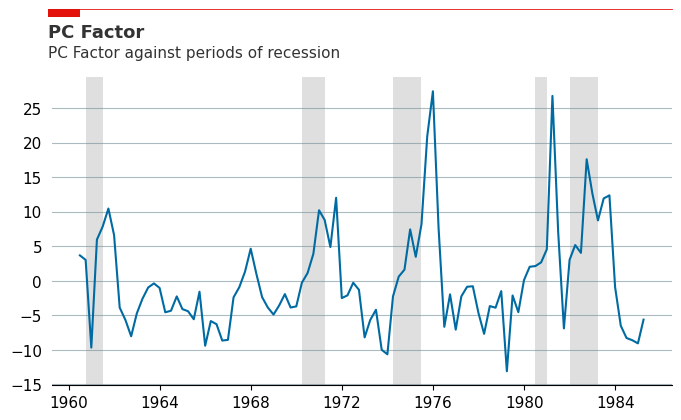

In [ ]:
fig, ax = plt.subplots()

ax.plot(new_df['Time'], sec3_pc, color='#006BA2', zorder = 2)


make_a_line()
make_a_rec()
make_title('PC Factor')
make_description("PC Factor against periods of recession")

recession = new_df.loc[new_df["rec"] == 1, 'Time']
for day in recession: 
    ax.axvspan(day, day + relativedelta(months =+ 3), color="grey", alpha = 0.25, lw= 0, zorder = 1)


plt.savefig('image\PC Facotr.png', bbox_inches='tight', dpi = 300)

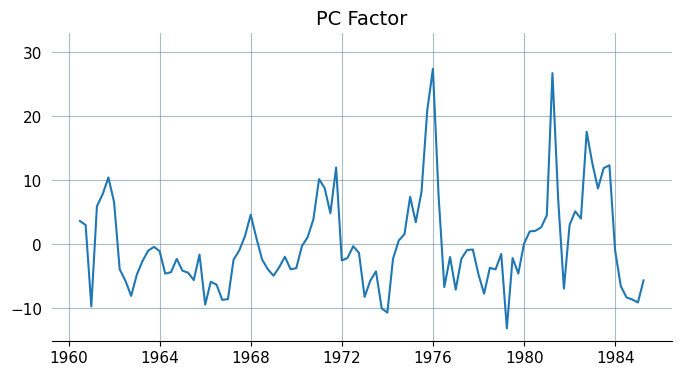

In [ ]:
plt.plot(df['Time'].iloc[:100], sec3_pc)
plt.title('PC Factor', fontsize = 14)
plt.ylim(top = 33)
#plt.plot(df['Time'].iloc[:100], df['GDPC1'].iloc[:100])
plt.grid(x)

plt.savefig('image\PC_factor.png', bbox_inches = 'tight')

In [ ]:
np.corrcoef(sec3_pc.flatten(), df['GDPC1'].iloc[:100])

array([[1.        , 0.13241645],
       [0.13241645, 1.        ]])

## **Section 4**

### Produce the plots for each model.

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Time'], df['tspread'], zorder = 2, linewidth = 1.5)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(x)
plot('Tspread', 'Difference of Market Yield on 10-year U.S. bond and 3-Month Treasury Bill')

plt.savefig('image\spread.png', bbox_inches = 'tight')

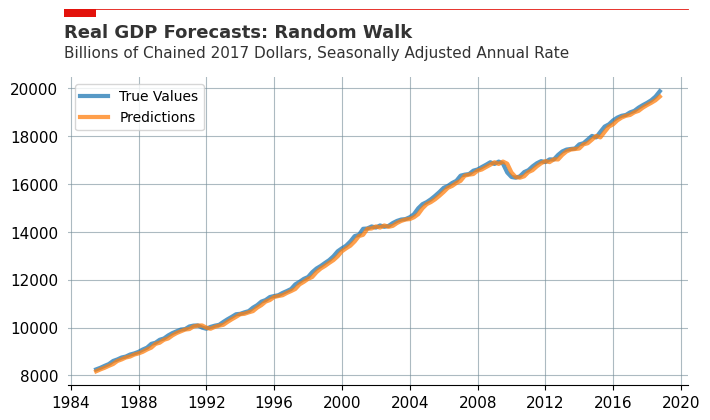

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['Time'].iloc[100:], df['GDPC1'].iloc[100:], zorder = 2, label = 'True Values', linewidth = 3, alpha = 0.75)
ax.plot(df['Time'].iloc[100:], exp_rw_predictions, zorder = 2, label='Predictions', linewidth = 3, alpha = 0.75)
plt.grid(x)
plt.legend()
plot('Real GDP Forecasts: Random Walk', 'Billions of Chained 2017 Dollars, Seasonally Adjusted Annual Rate')

plt.savefig('image\RW_forecasts.png', bbox_inches = 'tight')


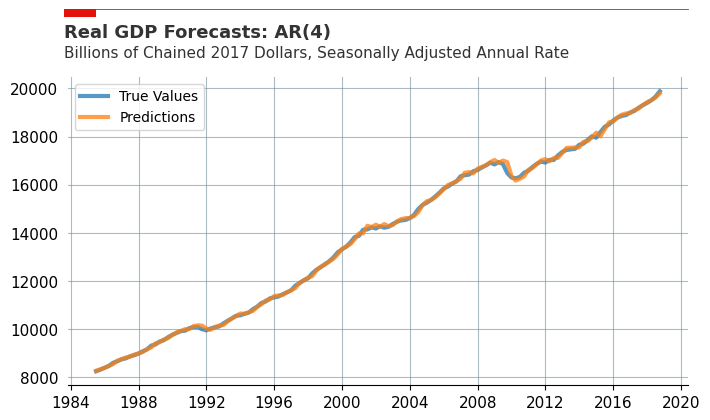

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['Time'].iloc[100:], df['GDPC1'].iloc[100:], zorder = 2, label = 'True Values', linewidth = 3, alpha = 0.75)
ax.plot(df['Time'].iloc[100:], ar_4_GDP_estimates, zorder = 2, label='Predictions', linewidth = 3, alpha = 0.75)
plt.grid(x)
plt.legend()
plt.figure
plot('Real GDP Forecasts: AR(4)', 'Billions of Chained 2017 Dollars, Seasonally Adjusted Annual Rate')
plt.savefig('image\AR4_forecasts.png', bbox_inches = 'tight')

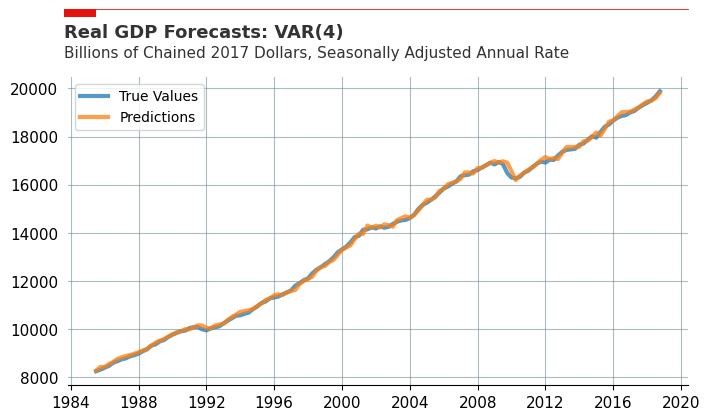

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['Time'].iloc[100:], df['GDPC1'].iloc[100:], zorder = 2, label = 'True Values', linewidth = 3, alpha = 0.75)
ax.plot(df['Time'].iloc[100:], var_4_GDP_estimates, zorder = 2, label='Predictions', linewidth = 3, alpha = 0.75)
plt.grid(x)
plt.legend()
plt.figure
plot('Real GDP Forecasts: VAR(4)', 'Billions of Chained 2017 Dollars, Seasonally Adjusted Annual Rate')
plt.savefig('image\VAR4_forecasts.png', bbox_inches = 'tight')

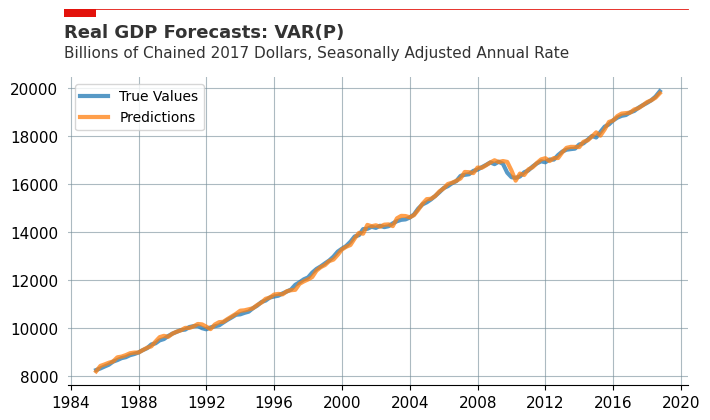

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['Time'].iloc[100:], df['GDPC1'].iloc[100:], zorder = 2, label = 'True Values', linewidth = 3, alpha = 0.75)
ax.plot(df['Time'].iloc[100:], var_p_GDP_estimates, zorder = 2, label='Predictions', linewidth = 3, alpha = 0.75)
plt.grid(x)
plt.legend()
plt.figure
plot('Real GDP Forecasts: VAR(P)', 'Billions of Chained 2017 Dollars, Seasonally Adjusted Annual Rate')
plt.savefig('image\VARP_forecasts.png', bbox_inches = 'tight')

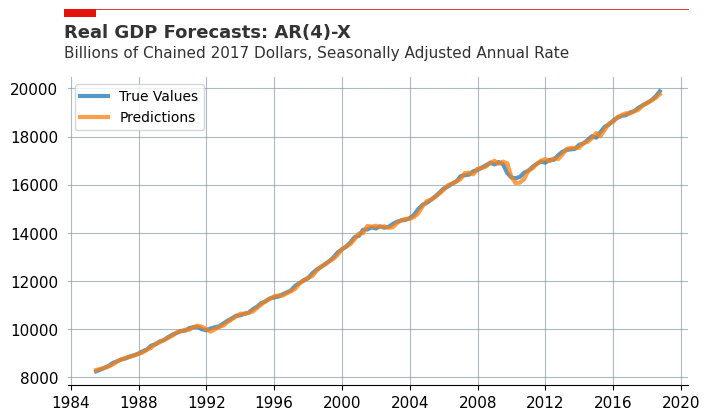

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['Time'].iloc[100:], df['GDPC1'].iloc[100:], zorder = 2, label = 'True Values', linewidth = 3, alpha = 0.75)
ax.plot(df['Time'].iloc[100:], ar_x_GDP_estimates, zorder = 2, label='Predictions', linewidth = 3, alpha = 0.75)
plt.grid(x)
plt.legend()
plt.figure
plot('Real GDP Forecasts: AR(4)-X', 'Billions of Chained 2017 Dollars, Seasonally Adjusted Annual Rate')
plt.savefig('image\Arx_forecasts.png', bbox_inches = 'tight')

### Compute RMSE for each model

In [81]:
rmse_rw = mean_squared_error(df['GDPC1'].iloc[100:], exp_rw_predictions, squared=False).round(2)
print(rmse_rw)

119.44


In [80]:
rmse_ar4 = mean_squared_error(df['GDPC1'].iloc[100:], ar_4_GDP_estimates, squared=False).round(2)
print(rmse_ar4)

79.98


In [79]:
rmse_var4 = mean_squared_error(df['GDPC1'].iloc[100:], var_4_GDP_estimates, squared=False).round(2)
print(rmse_var4)

93.38


In [77]:
rmse_var_p = mean_squared_error(df['GDPC1'].iloc[100:], var_p_GDP_estimates, squared=False).round(2)
print(rmse_var_p)

97.83


In [78]:
rmse_ar_x = mean_squared_error(df['GDPC1'].iloc[100:], ar_x_GDP_estimates, squared=False).round(2)
print(rmse_ar_x)

83.57


Barplot for all RMSE comparison.

In [83]:
models = ['RW', 'AR(4)', 'VAR(4)', 'VAR(p)', 'AR-X']
msfe_values = [rmse_rw,
               rmse_ar4,
               rmse_var4,
               rmse_var_p,
               rmse_ar_x]

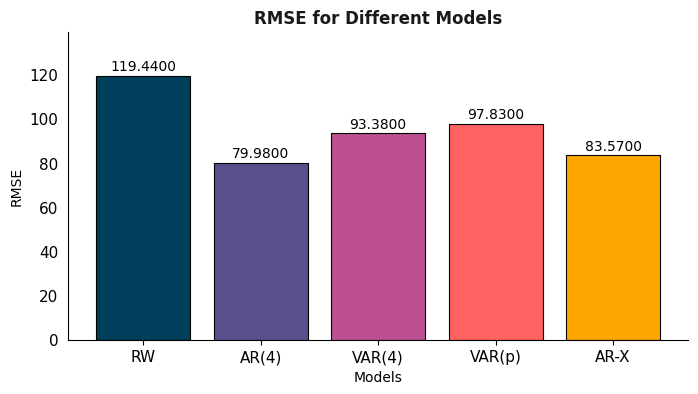

In [84]:
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']
fig,ax = plt.subplots()
plt.bar(models, msfe_values, color = colors, edgecolor = 'black', linewidth = 0.8)

# Add data labels above each bar
for i, rmse in enumerate(msfe_values):
    plt.text(i, rmse+1, f'{rmse:.4f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE for Different Models', weight = 'bold', alpha = 0.9)
plt.ylim(0, max(msfe_values) + 20)

plt.grid(axis = 'y')
ax.spines.left.set_visible(True)

plt.savefig('image\RMSE.png')

0.007509639422965608